# An fMRI study of composition in noun and verb phrases
### Bonnasse-Gahot, Bemis, Perez-Guevara, Dehaene, Pallier
Behavioral analysis. (Re)producing Fig. 4 and Supplementary Fig. S1

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

import os.path as op

import simpcomp as sc

from rpy2 import robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr
base = importr('base')
ez = importr('ez')

/home/lbg/anaconda3/lib/python3.6/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [2]:
sc.make_dir(sc.figures_folder)

In [3]:
sns.set_style('whitegrid', {'grid.linestyle': ':'})

In [4]:
results = pd.read_csv(op.join(sc.home_folder, 'sourcedata', 'simpcomp_behavioral_data.csv'))

results.loc[results.rt > 2400,'acc'] = 0
results['acc'] = 100*results['acc'] # expressed in percent
results['err'] = 100-results['acc']

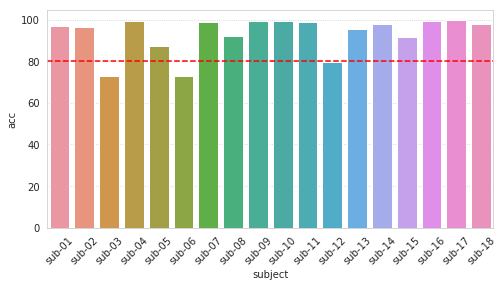

In [5]:
# behavioral accuracy

fh = plt.figure(figsize=(8,4))
g = sns.barplot(x='subject', y='acc', data=results, ci=None)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.axhline(80, ls='--', c='r')
plt.show()

In [6]:
# we excluded subjects 3, 6 and 12 from the rest of the study because of their
# very poor performance (error rates larger than 20% in the probe detection task,
# where only 1 to 4 words had to be memorized), suggesting that they did not pay
# enough attention to the stimuli
# the 15 remaining subjects defined the sc.subject_list variable

## I. error rate

In [7]:
results = results[np.in1d(results.subject, sc.subject_list)]
res = ez.ezANOVA(data=results, dv=base.as_symbol('err'), wid=base.as_symbol('subject'), 
                 within=base.as_symbol('structure,type,length'))
print(res)

R[write to console]: Warning:
R[write to console]:  Converting "subject" to factor for ANOVA.

R[write to console]: Warning:
R[write to console]:  Converting "structure" to factor for ANOVA.

R[write to console]: Warning:
R[write to console]:  Converting "type" to factor for ANOVA.

R[write to console]: Warning:
R[write to console]:  "length" will be treated as numeric.

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  There is at least one numeric within variable, therefore aov() will be used for computation and no assumption checks will be obtained.



$ANOVA
                 Effect DFn DFd          F          p p<.05         ges
1             structure   1  14 0.45845428 0.50938152       0.006586510
2                  type   1  14 0.27752294 0.60657628       0.002217376
3                length   1  14 4.33337314 0.05620424       0.086936253
4        structure:type   1  14 0.02777778 0.87001555       0.000165268
5      structure:length   1  14 0.06670404 0.79995569       0.001060438
6           type:length   1  14 2.42063244 0.14205780       0.008048854
7 structure:type:length   1  14 3.15747331 0.09730447       0.005555941




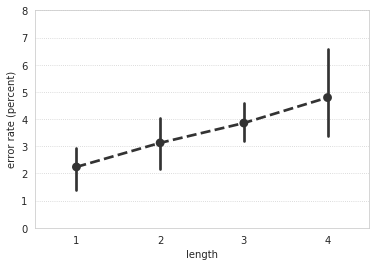

In [8]:
results_tmp_agg = results.groupby(['subject', 'length'], as_index=False).mean()

# removing the effects of Subject (see Cousineau, 2005)
grand_mean_tmp = results_tmp_agg['err'].mean()
for sub_id in sc.subject_list:
    results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'err'] = (
        results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'err']
        - results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'err'].mean()
        + grand_mean_tmp)

fh = plt.figure(figsize=(6,4))
sns.pointplot(x='length', y='err', data=results_tmp_agg, linestyles='--', n_boot=10000, color='0.2')
plt.ylabel('error rate (percent)')
plt.ylim(0,8)
plt.show()
fh.savefig(op.join(sc.figures_folder, 'behavioral_results_err.pdf'), bbox_inches='tight')

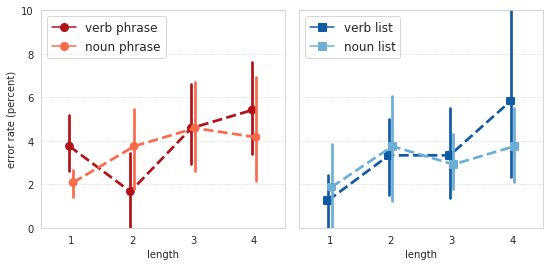

In [9]:
results_tmp_agg = results.groupby(['subject', 'length', 'structure', 'type'], as_index=False).mean()

# removing the effects of Subject (see Cousineau, 2005)
grand_mean_tmp = results_tmp_agg['err'].mean()
for sub_id in sc.subject_list:
    results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'err'] = (
        results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'err']
        - results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'err'].mean()
        + grand_mean_tmp)

darkred_marker = mlines.Line2D([], [], color=sc.color[0], marker='o', label='verb phrase',  markersize=8)
lightred_marker = mlines.Line2D([], [], color=sc.color[2], marker='o', label='noun phrase',  markersize=8)
darkblue_marker = mlines.Line2D([], [], color=sc.color[3], marker='s', label='verb list',  markersize=8)
lightblue_marker = mlines.Line2D([], [], color=sc.color[5], marker='s', label='noun list',  markersize=8)

fh = plt.figure(figsize=(9,4))
contrast_list = ['phrase_verb', 'phrase_noun']

gs = GridSpec(1, 2, wspace=0.06)
ax = plt.subplot(gs[0, 0])

g = sns.pointplot(x='length', y='err', hue='type', hue_order=['verb', 'noun'],
            data=results_tmp_agg[results_tmp_agg.structure=='phrase'], kind='point',
            markers=['o','o'], legend=True, dodge=0.06,
            palette=sc.color[[0,2]], ax=ax,
            linestyles='--', n_boot=1000)
g.legend(handles=[darkred_marker, lightred_marker],
         loc='upper left', title='', fontsize=12, title_fontsize=12)
plt.ylabel('error rate (percent)')
plt.ylim(0,10)

ax = plt.subplot(gs[0, 1])
g = sns.pointplot(x='length', y='err', hue='type', hue_order=['verb', 'noun'],
            data=results_tmp_agg[results_tmp_agg.structure=='list'], kind='point',
            markers=['s','s'], legend=True, dodge=0.06,
            palette=sc.color[[3,5]], ax=ax,
            linestyles='--', n_boot=10000)
g.legend(handles=[darkblue_marker, lightblue_marker],
         loc='upper left', title='', fontsize=12, title_fontsize=12)
ax.set_ylabel('')
ax.set_yticklabels('')
plt.ylim(0,10)
plt.show()

fh.savefig(op.join(sc.figures_folder, 'behavioral_results_err_detailed.pdf'), bbox_inches='tight')

## II. reaction times

In [10]:
results = results[np.in1d(results.subject, sc.subject_list)&(results.acc==100)&(results.rt>200)]

res = ez.ezANOVA(data=results, dv=base.as_symbol('rt'), wid=base.as_symbol('subject'), 
                 within=base.as_symbol('structure, type, length'))
print(res)

R[write to console]: Warning:
R[write to console]:  Converting "subject" to factor for ANOVA.

R[write to console]: Warning:
R[write to console]:  Converting "structure" to factor for ANOVA.

R[write to console]: Warning:
R[write to console]:  Converting "type" to factor for ANOVA.

R[write to console]: Warning:
R[write to console]:  "length" will be treated as numeric.

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  There is at least one numeric within variable, therefore aov() will be used for computation and no assumption checks will be obtained.



$ANOVA
                 Effect DFn DFd            F            p p<.05          ges
1             structure   1  14  1.418763224 2.534104e-01       8.666100e-03
2                  type   1  14  0.004003403 9.504441e-01       8.076211e-05
3                length   1  14 65.251676602 1.223236e-06     * 4.751081e-01
4        structure:type   1  14  0.668985881 4.271074e-01       5.463485e-03
5      structure:length   1  14  0.099918354 7.565911e-01       1.026598e-03
6           type:length   1  14  0.012011131 9.142858e-01       6.102318e-05
7 structure:type:length   1  14  2.367792455 1.461537e-01       1.777481e-02




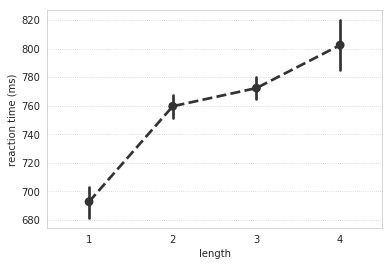

In [11]:
results_tmp_agg = results.groupby(['subject', 'length'], as_index=False).mean()

# removing the effects of Subject (see Cousineau, 2005)
grand_mean_tmp = results_tmp_agg['rt'].mean()
for sub_id in sc.subject_list:
    results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'rt'] = (
        results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'rt']
        - results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'rt'].mean()
        + grand_mean_tmp)

fh = plt.figure(figsize=(6,4))
sns.pointplot(x='length', y='rt', data=results_tmp_agg, linestyles='--', n_boot=10000, color='0.2')
plt.ylabel('reaction time (ms)')
plt.show()
fh.savefig(op.join(sc.figures_folder, 'behavioral_results_rt.pdf'), bbox_inches='tight')

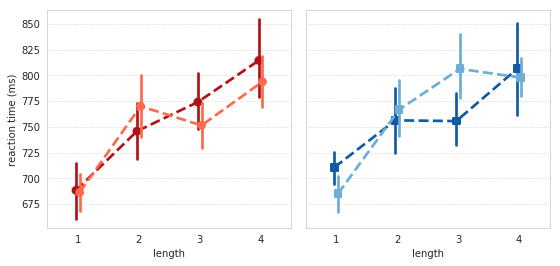

In [12]:
results_tmp_agg = results.groupby(['subject', 'length', 'structure', 'type'], as_index=False).mean()

# removing the effects of Subject (see Cousineau, 2005)
grand_mean_tmp =results_tmp_agg['rt'].mean()
for sub_id in sc.subject_list:
    results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'rt'] = (
        results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'rt']
        - results_tmp_agg.loc[results_tmp_agg.subject==sub_id, 'rt'].mean()
        + grand_mean_tmp)

fh = plt.figure(figsize=(9,4))
gs = GridSpec(1, 2, wspace=0.06)

ax = plt.subplot(gs[0, 0])
g = sns.pointplot(x='length', y='rt', hue='type', hue_order=['verb', 'noun'],
            data=results_tmp_agg[results_tmp_agg.structure=='phrase'], kind='point',
            markers=['o','o'], legend=False, dodge=0.06,
            palette=sc.color[[0,2]], ax=ax,
            linestyles='--', n_boot=10000)
g.legend_ = None
plt.ylabel('reaction time (ms)')
plt.ylim(652,863)

ax = plt.subplot(gs[0, 1])
g = sns.pointplot(x='length', y='rt', hue='type', hue_order=['verb', 'noun'],
            data=results_tmp_agg[results_tmp_agg.structure=='list'], kind='point',
            markers=['s','s'], legend=False, dodge=0.06,
            palette=sc.color[[3,5]], ax=ax,
            linestyles='--', n_boot=10000)
g.legend_ = None
ax.set_ylabel('')
ax.set_yticklabels('')
plt.ylim(652,863)
plt.show()

fh.savefig(op.join(sc.figures_folder, 'behavioral_results_rt_detailed.pdf'), bbox_inches='tight')